# Lleva a cabo la evaluación del Modelo Entrenado YOLO exportado como ONNX y aplicando la librería OpenCV para comparar contra los objetos indicados en los XMLs o LABELs correspondientes
- el modelo YOLO fue entrenado con la librería https://docs.ultralytics.com/es/ pero no se usa aquí
- se usa librería openCV basado en ejemplo de https://github.com/ultralytics/ultralytics/blob/main/examples/YOLOv8-OpenCV-ONNX-Python/main.py

# Preparación del entorno:

In [1]:
#@title Cargar Librerías
import os
import os.path
import sys
import numpy as np
import pandas as pd


import random

from IPython.display import Image, display
from PIL import Image as ImPIL
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import copy

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

import time
import tempfile

import cv2
from google.colab.patches import cv2_imshow

print ("Librerías cargadas.")

Librerías cargadas.


In [2]:
#@title Montar Google Drive
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Configuración del entorno:

In [3]:
#@title Definir funciones auxiliares

# función para cálculo de Intersection over Union (IoU)
def calc_IoU( gt_bbox, pred_bbox):
    # This function takes the predicted bounding box and ground truth bounding box
    # and returnr the IoU ratio
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        return 0.0
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    # coordinates
    x_top_left = np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    # calculate areas
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
    # reutrn IoU
    return intersection_area/union_area


# lista de colores para clases (se inicializa con initialize_class_colors)
class_colors_list = None

def initialize_class_colors(num_classes):
    # inicializa colores para las clases
    global class_colors_list
    class_colors_list = []
    for i in range(num_classes):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        color = (r, g, b)
        if color not in class_colors_list:
          class_colors_list.append(color)


def get_class_color(classId):
    # devuelve el color correspondiente para una clase
    global class_colors_list
    if (class_colors_list is None) or (len(class_colors_list)<classId):
      initialize_class_colors(max(1000, classId+1))
    return class_colors_list[classId]


def draw_text_on_img(draw, display_str_list, box, color):
    # función para mostrar texto en imagen
    (left, top, right, bottom) = box
    try:
      font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
      font = ImageFont.load_default()
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top #- total_display_str_height
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]
        margin = np.ceil(0.05 * text_height)
        # coloca rectangulo para el texto
        draw.rectangle(
            [(left, text_bottom - text_height - 2 * margin),
            (left + text_width, text_bottom)],
            fill=color)
        # coloca el texto
        draw.text(
            (left + margin, text_bottom - text_height - margin),
            display_str,
            fill='black', font=font)
        text_bottom -= text_height - 2 * margin


def draw_box_on_image(draw, box, lineColor, line_width=4, label=None):
    # dibuja en la imagen
    draw.rectangle(box, outline=lineColor, width=line_width)
    # si tiene que incluir nombre clase
    if (label is not None) and (len(label)>0):
      draw_text_on_img(draw, display_str_list=[label], box=box, color=lineColor)


def draw_boxes_listObj(draw, listObj, lineColor, lineWidth=4):
    # función para mostrar boxes de una lista objetos en una imagen dada
    for obj in listObj:
      draw_box_on_image(draw, box=obj[2], lineColor=lineColor, line_width=lineWidth, label=None)

# función para cálculo de las métricas (matriz de confusión, gráfico (opcional) y class report (opcional)
def mostrarMetricas(objReal, objModelo, titulo="", showConfussionGraph=False, showClassReport=False, labels_clases_map=None, etiqueta_modelo="M", etiqueta_real="R"):
    if labels_clases_map is None:
      # si no está defindo, lo genera
      labels_clases_map = list(set(objReal + objModelo))
      labels_clases_map.sort()
    if len(labels_clases_map)==0:
      print("No se definieron los datos de las clases para mostrar métricas!")
      return
    # matriz de confusión
    print("\n> Matriz de Confusión " + titulo + ": ")
    cm = confusion_matrix(y_true=objReal, y_pred=objModelo, labels=labels_clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=[etiqueta_real+':{:}'.format(x) for x in labels_clases_map],
        columns=[etiqueta_modelo+':{:}'.format(x) for x in labels_clases_map]
      )
    display(cmtx)
    print("")
    if showConfussionGraph:
        # gráfico de confusión
        dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=labels_clases_map)
        fig, ax = plt.subplots(figsize=(15,5))
        dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
        dispCM.ax_.set_title("Gráfico de Confusión " + titulo + ": ")
        dispCM.ax_.set(xlabel='- '+ etiqueta_modelo +' -', ylabel='- '+ etiqueta_real +' -')
        plt.tight_layout()
        plt.show()
        print("")
    if showClassReport:
        # muestra reporte de clasificación
        print("\n> Reporte de Clasificación " + titulo + ": ")
        print(classification_report(y_true=objReal, y_pred=objModelo, zero_division=1.0))
        print("")
    return

def convert_bbox_to_yolo(size, box):
    # size = (width, height)
    # box = (xmin, ymin, xmax, ymax)
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x_center_abs = (box[0] + box[2]) / 2.0
    y_center_abs = (box[1] + box[3]) / 2.0
    width_abs = box[2] - box[0]
    height_abs = box[3] - box[1]
    x_center = x_center_abs * dw
    y_center = y_center_abs * dh
    width = width_abs * dw
    height = height_abs * dh
    return (x_center, y_center, width, height)

def convert_yolo_to_bbox(yolo, image_size):
    # yolo = (x_center, y_center, width, height)
    # image_size = (dw, dh)
    dw, dh = image_size
    x, y, w, h = yolo
    x1 = int((x - w / 2) * dw)
    x2 = int((x + w / 2) * dw)
    y1 = int((y - h / 2) * dh)
    y2 = int((y + h / 2) * dh)
    if x1 < 0:
        x1 = 0
    if x2 > dw - 1:
        x2 = dw - 1
    if y1 < 0:
        y1 = 0
    if y2 > dh - 1:
        y2 = dh - 1
    # (xmin, ymin, xmax, ymax)
    return (x1, y1, x2, y2)


def check_bbox(rangeBox):
    # si tiene invertidas las posiciones las corrige
    if rangeBox[0] > rangeBox[2]:
      aux = rangeBox[2]
      rangeBox[2] = rangeBox[0]
      rangeBox[0] = aux
    if rangeBox[1] > rangeBox[3]:
      aux = rangeBox[3]
      rangeBox[3] = rangeBox[1]
      rangeBox[1] = aux
    return rangeBox

def calcule_bbox_centroide(rangeBox):
  # calcula un valor para poder ordenar las figuras de arriba a abajo y izquierda a derecha
  return rangeBox[1]*100000+rangeBox[0]

def load_LABEL(labelFN):
  # carga información de archivo LABEL
   # devuelve: classId, className(None) y 4 corrdenadas formato YOLO
  if not os.path.isfile(labelFN):
    print("\t ERROR: no se encuentra el archivo ", labelFN, " !")
    return []
  with open(labelFN, 'r') as f:
    data = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      auxi = line.split(" ")
      class_id = int(auxi[0])
      rangoIm = ( float(auxi[1]),
                  float(auxi[2]),
                  float(auxi[3]),
                  float(auxi[4]) )
      data.append( (class_id, None, rangoIm) )
  return data

def load_XML(xmlFN):
  if not os.path.isfile(xmlFN):
    print("\t ERROR: no se encuentra el archivo ", xmlFN, " !")
    return []
  # carga información de archivo XML
   # devuelve: classId(None), className y 4 coordenadas formato COCO
  et = ET.parse(xmlFN)
  element = et.getroot()
  element_objs = element.findall('object')
  #element_filename = element.find('filename').text
  #imagenProcesar = os.path.join(dirTestImg, element_filename)
  # carga los elementos en el archivo XML original para generar el nuevo
  data = []
  for element_obj in element_objs:
      # obtiene la información actual de la imagen
      class_name = element_obj.find('name').text
      # obtiene info del box actual
      obj_bbox = element_obj.find('bndbox')
      rangoIm = ( float(obj_bbox.find('xmin').text),
                      float(obj_bbox.find('ymin').text),
                      float(obj_bbox.find('xmax').text),
                      float(obj_bbox.find('ymax').text) )
      data.append( (None, class_name, rangoIm) )
  return data

def preparar_datos_XML_o_Label(esXML, data, classMap, image_size):
  # normaliza los datos de XML o Label a un formato unificado
  # devuelve: classId, className y 4 coordenadas formato COCO
  if data is None:
    return None
  newData = []
  if esXML:
      # para XML se necesita convertir de nombre a id
      classMap_swapped = {value: key for key, value in classMap.items()}
      # procesa datos cargados de XML
      for d in data:
        # obtiene ID de la clase correspondiente
        class_name = d[1]
        if class_name in classMap_swapped:
          class_id = classMap_swapped[class_name]
        else:
          class_id = -1
        # determina rangos
        newRango = check_bbox(d[2])
        # determina centroide
        centroide = calcule_bbox_centroide(newRango)
        # determina datos a devolver (notar que es misma estructura que abajo
      newData.append( (centroide, class_name, newRango) )
  else:
      # procesa datos cargados de LABEL
      for d in data:
        # obtiene nombre de la clase
        class_id = d[0]
        if class_id in classMap:
          class_name = classMap[class_id]
        else:
          class_name = "id "+sr(class_id)
        newRango = check_bbox(convert_yolo_to_bbox(d[2], image_size))
        # determina centroide
        centroide = calcule_bbox_centroide(newRango)
        # determina datos a devolver (notar que es misma estructura que arriba)
        newData.append( (centroide, class_name, newRango) )
  return newData


def devolverArchivosDir(dir, extList=None):
  # devuelve lista de archivos en dir con extensión en extList o todos
  if not os.path.isdir(dir):
    print("No existe el directorio: ", dir)
    return []
  all = os.listdir(dir)
  if (extList is None) or (len(extList)==0):
    return len(all)
  else:
    res = []
    for fn in all:
      _, ext = os.path.splitext(fn)
      if ext.lower() in extList:
        res.append( fn )
    return res

print("Funciones auxiliares definidas")


Funciones auxiliares definidas


In [4]:
#@title Definir configuración de directorios local en Google Drive

#@markdown Carpeta del Modelo a usar:
path_modelo = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Modelo' #@param {type:"string"}

#@markdown Carpetas Datos:
path = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles' #@param {type:"string"}

subdir_Entrenamiento = '/train' #@param {type:"string"}
subdir_Validacion = '/validation' #@param {type:"string"}
subdir_Prueba = '/test' #@param {type:"string"}

#@markdown SubCarpetas tipo de Datos:
subdir_subdir_Imagenes = '/images'  #@param {type:"string"}
subdir_subdir_XML = '/annotations'  #@param {type:"string"}
subdir_subdir_LABEL = '/labels'  #@param {type:"string"}

#@markdown Tipos de Archivos:
ext_archivo_Imagen = ".jpg, .jpeg, .png" #@param {type:"string"}
ext_archivo_XML = ".xml" #@param {type:"string"}
ext_archivo_LABEL = ".txt" #@param {type:"string"}

# prepara extensiones
image_extensions = []
for e in ext_archivo_Imagen.split(","):
  e = e.strip()
  if "." not in e:
    e = e + "."
  image_extensions.append(e)

if "." not in ext_archivo_LABEL:
  ext_archivo_LABEL = "." + ext_archivo_LABEL

if "." not in ext_archivo_XML:
  ext_archivo_XML = "." + ext_archivo_XML

# determina directorios
dirDestTrain = path + subdir_Entrenamiento
dirDestVal = path + subdir_Validacion
dirDestTest = path + subdir_Prueba

print("Configuración de archivos definida")

Configuración de archivos definida


In [5]:
#@title Definir clase entrenadas

archivo_clases = "classes.txt" #@param {type:"string"}

def load_classes(classes_txt_path):
  if not os.path.isfile(classes_txt_path):
    print("\t ERROR: no se encuentra el archivo ", classes_txt_path, " disponible!")
    return []
  with open(classes_txt_path, 'r') as f:
    class_list = {}
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      data = line.split(":")
      class_list[int(data[0].strip())] = str(data[1].strip())
    return class_list


# define nombre archivo clases
classes_map_fname = path + '/classes.txt'
classes_map = None

# utiliza archivo existente
print("\n-- cargando archivo de clases: ", classes_map_fname)
classes_map = load_classes(classes_map_fname)

# muestra clases cargadas
if classes_map is not None:
  # inicializa colores para las clases
  initialize_class_colors(len(classes_map))
  print("\n> clases cargadas [" + str(len(classes_map)) + "]: ")
  for clId in classes_map.keys():
    print("\t id ", clId, " -> clase", classes_map[clId])




-- cargando archivo de clases:  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/classes.txt

> clases cargadas [10]: 
	 id  0  -> clase 2
	 id  1  -> clase 0
	 id  2  -> clase 8
	 id  3  -> clase 6
	 id  4  -> clase 4
	 id  5  -> clase 3
	 id  6  -> clase 1
	 id  7  -> clase 7
	 id  8  -> clase 9
	 id  9  -> clase 5


# Preparación del Modelo:

In [27]:
#@title Cargar Modelo YOLO exportado ONNX con OpenCV
# código basado de https://github.com/ultralytics/ultralytics/blob/main/examples/YOLOv8-OpenCV-ONNX-Python/main.py


modelo_entrenado_archivoONNX = "/best.onnx" #@param {type:"string"}

# tamaño definido en el entrenamiento
modelo_entrenado_imgsz="480" #@param [320, 480, 640]

# Carga el ONNX model
fnModel = path_modelo + modelo_entrenado_archivoONNX
model = cv2.dnn.readNetFromONNX(fnModel)
print("Modelo cargado: ", fnModel)

model_input_size = (int(modelo_entrenado_imgsz), int(modelo_entrenado_imgsz))
print("Modelo Image input size: ", model_input_size)

# inicializa lista colores para openCV
COLORS_OpenCV = np.random.uniform(0, 255, size=(len(classes_map.keys()), 3))


# función auxiliar para preparar la imagen
# para poder ser utilizada como entrada de modelo OpenCV
def prepararImagenOpenCV(imagePIL, model_input_size):
   # transform image PIL to OpenCV
    # Convert the color channel order from RGB  to BGR for OpenCV
    original_image =  cv2.cvtColor(np.array(imagePIL), cv2.COLOR_RGB2BGR)
      ## cv2.imread(fn_path)
    [height, width, _] = original_image.shape
    # Prepare a square image for inference
    length = max((height, width))
    image = np.zeros((length, length, 3), np.uint8)
    image[0:height, 0:width] = original_image
    # Calculate scale factor
    scale = length / model_input_size[0]
    # Preprocess the image and prepare blob for model
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0/255.0,
                                  size=model_input_size,
                                  swapRB=True)
    return blob, scale

# función auxiliar para preparar los detections de resultado
# del modelo OpenCV ejecutado
def prepararResultDetectionsOpenCV(outputs, scale, classes):
    # initialice variables
    boxes = []
    scores = []
    class_ids = []
    detections = []
    # Prepare output array
    outputs = np.array([cv2.transpose(outputs[0])])
    # Iterate through output to collect bounding boxes, confidence scores, and class IDs
    for i in range(outputs.shape[1]):
        classes_scores = outputs[0][i][4:]
        (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
        box = [
            outputs[0][i][0] - (0.5 * outputs[0][i][2]),  # x center - width/2 = left x
            outputs[0][i][1] - (0.5 * outputs[0][i][3]),  # y center - height/2 = top y
            outputs[0][i][2],  # width
            outputs[0][i][3],  # height
        ]
        boxes.append(box)
        scores.append(maxScore)
        class_ids.append(maxClassIndex)
    # Apply NMS (Non-maximum suppression)
    result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)
    # Iterate through NMS results to draw bounding boxes and labels
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes[index]
        # cambia formato de coordenadas a formato COCO
        bbox = {  'x1': round(box[0] * scale),
                  'y1': round(box[1] * scale),
                  'x2': round((box[0]+box[2]) * scale),
                  'y2': round((box[1]+box[3]) * scale)  }
        # agrega detection
        detection = {
            "class": class_ids[index],
            "name": classes[class_ids[index]],
            "confidence": scores[index],
            "box": bbox
        }
        detections.append(detection)
    return detections

# muestra la imagen con boxes usando OpenCV
def showImageBoxesOpenCV(imagePIL, resModel):
  original_image = np.array(imagePIL)
  for res in resModel:
      # dibuja el box en la imagen
      label = str(res["name"]) + " " + str(round(res["confidence"],2))
      color = COLORS_OpenCV[res["class"]]
      # muestra recuaddro
      cv2.rectangle(original_image,
                        (res["box"]["x1"], res["box"]["y1"]),
                        (res["box"]["x2"], res["box"]["y2"]),
                        color, 2)
      # muestra nombre clase
      cv2.putText(original_image, label,
                        (res["box"]["x1"], res["box"]["y1"]),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  # muestra la imagen
  cv2_imshow(original_image)

# función wrapper auxiliar para ejecutar el modelo con una imagen
def modelPredict(imagePIL, classes, showImageResults=True, verbose=False):
    # prapara la imagen y la ingresa al modelo
    blob, scale= prepararImagenOpenCV(imagePIL, model_input_size)
    model.setInput(blob)
    # ejecuta el modelo registrando el tiempo
    tiempoInicioModelo = time.time()
    outputs = model.forward()
    tiempoDemoraModelo = (time.time() - tiempoInicioModelo)
    if verbose:
      print("\t Ejecutar el modelo demora ", round(tiempoDemoraModelo, 5), " segundos. ")
    # prepara salida de detections
    resModel = prepararResultDetectionsOpenCV(outputs, scale, classes)
    # si corresponde muestra resultados
    if showImageResults:
      showImageBoxesOpenCV(imagePIL, resModel)
      print(" Resultados del Modelo:")
      for res in resModel:
          print("\t", res)

    return resModel, tiempoDemoraModelo

def preparar_resultados_modelo(modelResult, filter_min_confidence=0.0, muestraDebug=False):
  # estandariza resultaods de modelo a lista de valores  (centroide, class_id, class_name, rangoBox)
  # hay que definilo para cada tipo de modelo porque cada librería lo maneja distinto
  if modelResult is None:
    return None
  newRes = []
  for res in modelResult:
      # determina confianza
      confidence = res['confidence']
      # determina clase
      class_id = res['class']
      class_name = res['name']
      # determina rango
      auxBox = res['box']
      rangoBox = ( auxBox['x1'], auxBox['y1'], auxBox['x2'], auxBox['y2'] )
      rangoBox = check_bbox( rangoBox )
      # si el objeto detectado tiene un puntaje superior o igual al mínimo
      if confidence >= filter_min_confidence:
          # calcula un valor para poder ordenar las figuras de arriba a abajo y izquierda a derecha
          centroide = calcule_bbox_centroide(rangoBox)
          # determina datos a devolver (notar que es misma estructura que función <preparar_datos_XML_o_Label>)
          newRes.append( (centroide, class_name, rangoBox)  )
      else:
          if muestraDetalleDebug and confidence >= 0.3:
            print("-- Objeto descartado por bajo score: ", class_name, "(", confidence*100, "%) en ", rangoBox)
  return newRes


Modelo cargado:  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Modelo/best.onnx
Modelo Image input size:  (480, 480)



 > cartel_003728325944542.png :


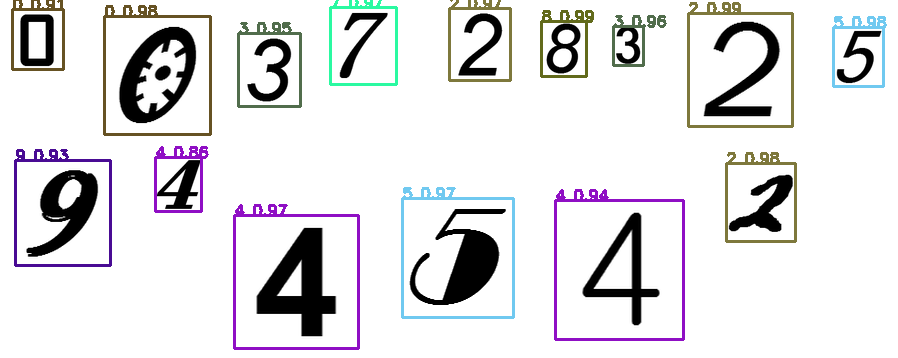

 Resultados del Modelo:
	 {'class': 2, 'name': '8', 'confidence': 0.9857762455940247, 'box': {'x1': 541, 'y1': 21, 'x2': 586, 'y2': 76}}
	 {'class': 0, 'name': '2', 'confidence': 0.985511839389801, 'box': {'x1': 688, 'y1': 13, 'x2': 792, 'y2': 126}}
	 {'class': 9, 'name': '5', 'confidence': 0.9843202829360962, 'box': {'x1': 833, 'y1': 27, 'x2': 883, 'y2': 86}}
	 {'class': 1, 'name': '0', 'confidence': 0.9838534593582153, 'box': {'x1': 104, 'y1': 16, 'x2': 210, 'y2': 134}}
	 {'class': 0, 'name': '2', 'confidence': 0.9758055210113525, 'box': {'x1': 726, 'y1': 163, 'x2': 795, 'y2': 241}}
	 {'class': 0, 'name': '2', 'confidence': 0.9705533385276794, 'box': {'x1': 449, 'y1': 8, 'x2': 510, 'y2': 80}}
	 {'class': 4, 'name': '4', 'confidence': 0.9677790403366089, 'box': {'x1': 234, 'y1': 215, 'x2': 358, 'y2': 348}}
	 {'class': 9, 'name': '5', 'confidence': 0.9665880799293518, 'box': {'x1': 402, 'y1': 198, 'x2': 513, 'y2': 317}}
	 {'class': 7, 'name': '7', 'confidence': 0.9664403796195984, 'box

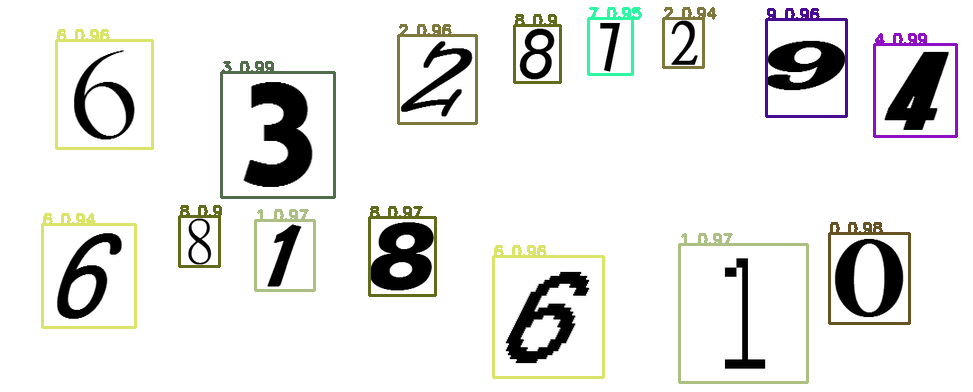

 Resultados del Modelo:
	 {'class': 5, 'name': '3', 'confidence': 0.9943002462387085, 'box': {'x1': 221, 'y1': 72, 'x2': 334, 'y2': 197}}
	 {'class': 4, 'name': '4', 'confidence': 0.990500271320343, 'box': {'x1': 874, 'y1': 44, 'x2': 956, 'y2': 136}}
	 {'class': 1, 'name': '0', 'confidence': 0.9835422039031982, 'box': {'x1': 829, 'y1': 233, 'x2': 909, 'y2': 323}}
	 {'class': 2, 'name': '8', 'confidence': 0.9743847846984863, 'box': {'x1': 369, 'y1': 217, 'x2': 435, 'y2': 295}}
	 {'class': 6, 'name': '1', 'confidence': 0.9738051891326904, 'box': {'x1': 255, 'y1': 220, 'x2': 314, 'y2': 290}}
	 {'class': 6, 'name': '1', 'confidence': 0.9688236713409424, 'box': {'x1': 679, 'y1': 244, 'x2': 807, 'y2': 382}}
	 {'class': 0, 'name': '2', 'confidence': 0.962493896484375, 'box': {'x1': 398, 'y1': 35, 'x2': 476, 'y2': 123}}
	 {'class': 8, 'name': '9', 'confidence': 0.9586072564125061, 'box': {'x1': 766, 'y1': 19, 'x2': 846, 'y2': 116}}
	 {'class': 3, 'name': '6', 'confidence': 0.9569235444068909, 

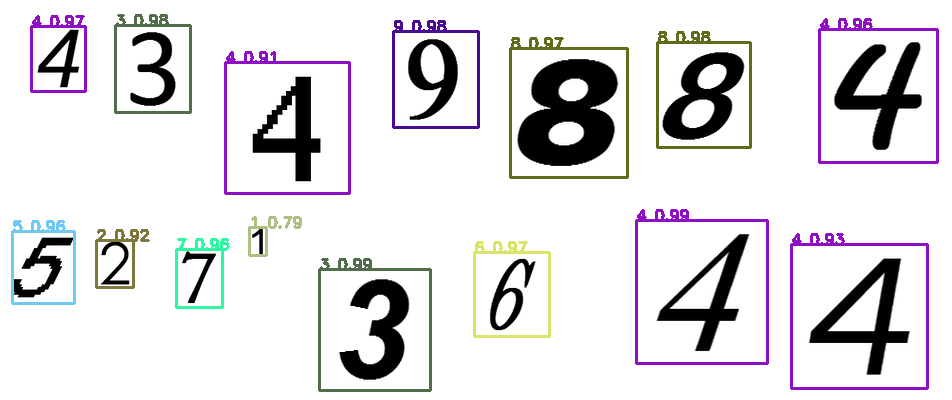

 Resultados del Modelo:
	 {'class': 5, 'name': '3', 'confidence': 0.9891208410263062, 'box': {'x1': 319, 'y1': 269, 'x2': 430, 'y2': 390}}
	 {'class': 4, 'name': '4', 'confidence': 0.985874593257904, 'box': {'x1': 636, 'y1': 220, 'x2': 767, 'y2': 363}}
	 {'class': 2, 'name': '8', 'confidence': 0.9837576746940613, 'box': {'x1': 657, 'y1': 42, 'x2': 750, 'y2': 147}}
	 {'class': 8, 'name': '9', 'confidence': 0.978049099445343, 'box': {'x1': 393, 'y1': 31, 'x2': 478, 'y2': 127}}
	 {'class': 5, 'name': '3', 'confidence': 0.977159321308136, 'box': {'x1': 115, 'y1': 25, 'x2': 190, 'y2': 112}}
	 {'class': 2, 'name': '8', 'confidence': 0.97447270154953, 'box': {'x1': 510, 'y1': 48, 'x2': 627, 'y2': 177}}
	 {'class': 4, 'name': '4', 'confidence': 0.9686078429222107, 'box': {'x1': 31, 'y1': 26, 'x2': 85, 'y2': 91}}
	 {'class': 3, 'name': '6', 'confidence': 0.9666043519973755, 'box': {'x1': 474, 'y1': 252, 'x2': 549, 'y2': 336}}
	 {'class': 4, 'name': '4', 'confidence': 0.9649601578712463, 'box': 

In [28]:
#@title Ejecutar Modelo con ejemplos

#@title Seleccionar y cargar las imágenes para usar en la prueba
fuente_imgenes = "Prueba" #@param ["Entrenamiento", "Validación", "Prueba"]
cant_imagenes = 3 #@param {type:"integer"}

if cant_imagenes>0:

  # deterimina fuente
  if fuente_imgenes == "Entrenamiento":
    dir_imagenes = dirDestTrain+subdir_subdir_Imagenes
  elif  fuente_imgenes == "Prueba":
    dir_imagenes = dirDestTest+subdir_subdir_Imagenes
  else:
    dir_imagenes = dirDestVal+subdir_subdir_Imagenes

  # toma imágenes al azar
  all_images_array = [ fn for fn in os.listdir( dir_imagenes)  ]
  np.random.shuffle(all_images_array)
  sel_images_array, _ = np.split(np.array(all_images_array), [cant_imagenes])

  # procea y muestra resultados
  for fn in sel_images_array:
    fn_path = dir_imagenes+"/"+fn
    print("\n >", fn, ":")

    # carga la imagen
    imageCargada = ImPIL.open(fn_path)
    #display( imageCargada )

    # ejecuta el modelo y recibe resultados
    modelPredict(imagePIL=imageCargada,
                 classes=classes_map,
                 showImageResults=True)


# Evaluación del Modelo contra datos de LABELs:

In [35]:
#@title Definir imágenes y datos a utilizar

# define la carpeta donde están las imágenes para procesar
fuente_datos = "Prueba" #@param ["Entrenamiento", "Validación", "Prueba"]

porc_datos_procesar = 100 #@param {type:"slider", min:1, max:100, step:1}

tipo_datos_comparar = "LABEL" #@param ["LABEL", "XML"]

# determina si usa como fuente de datos
# archivos XML o LABEL
usarDatosXML = (tipo_datos_comparar == "XML")

# determina fuente de datos
if fuente_datos == "Entrenamiento":
  dirImg = dirDestTrain + subdir_subdir_Imagenes  + "/"
  dirData = dirDestTrain
elif fuente_datos == "Validación":
  dirImg = dirDestVal + subdir_subdir_Imagenes  + "/"
  dirData = dirDestVal
#elif fuente_datos == "Prueba":
else:
  dirImg = dirDestTest + subdir_subdir_Imagenes  + "/"
  dirData = dirDestTest
if usarDatosXML:
  dirData = dirData + subdir_subdir_XML  + "/"
else:
  dirData = dirData + subdir_subdir_LABEL  + "/"


# determina total imágenes disponibles
process_FileNames = devolverArchivosDir(dirImg, image_extensions)
print("\n> Total de imágenes disponibles: ", len(process_FileNames))


# levanta las imágenes a ser utilizadas
if porc_datos_procesar<=0:
    process_Image_FileNames = []
elif porc_datos_procesar<100:
    process_Image_FileNames = random.sample(process_FileNames, int(len(process_FileNames)*porc_datos_procesar/100.0))
else:  #porcMuestraImagenesProcesar>=100 -> usa todos
    process_Image_FileNames = process_FileNames

print("\n> Imágenes a ser usadas en la evaluación: ", len(process_Image_FileNames))



> Total de imágenes disponibles:  100

> Imágenes a ser usadas en la evaluación:  100



------------------------------------------------------------------------------------------------------------
< 1 >  cartel_967876129293049.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 2 >  cartel_709971849076183.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 3 >  cartel_351443877003368.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 4 >  cartel_803339561315815.png : 


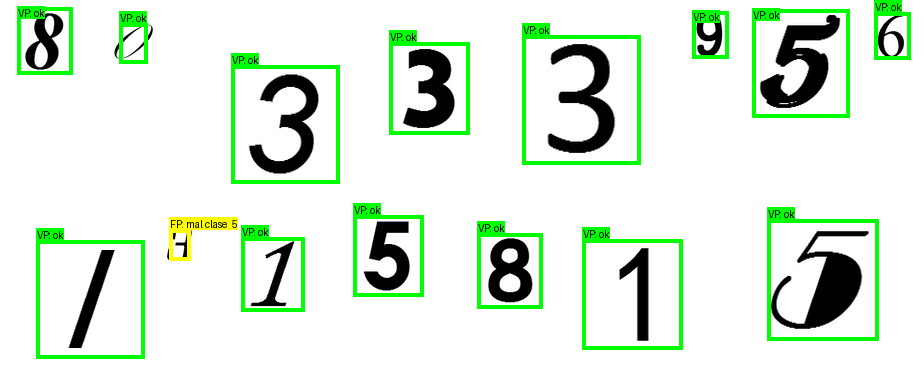

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,0
LABEL:-,1,0




------------------------------------------------------------------------------------------------------------
< 5 >  cartel_003728325944542.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 6 >  cartel_562670007597818.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 7 >  cartel_994717697816264.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 8 >  cartel_015830970701524.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 9 >  cartel_331562515464447.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 10 >  cartel_89617785475845

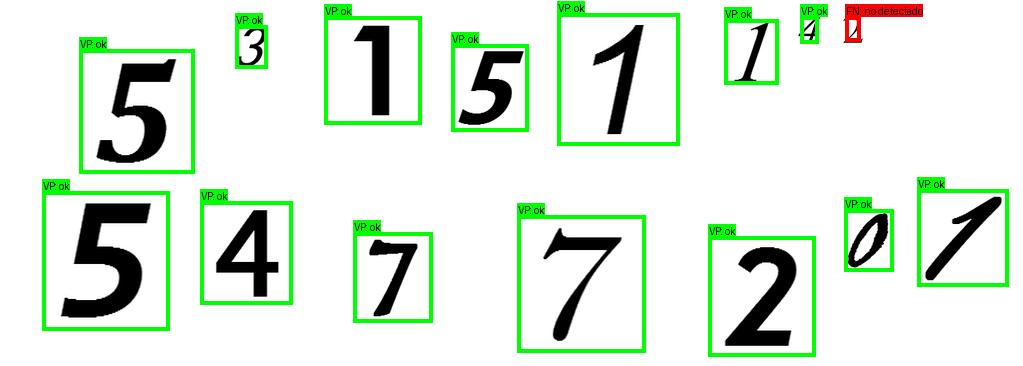

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 13 >  cartel_175525882114838.png : 


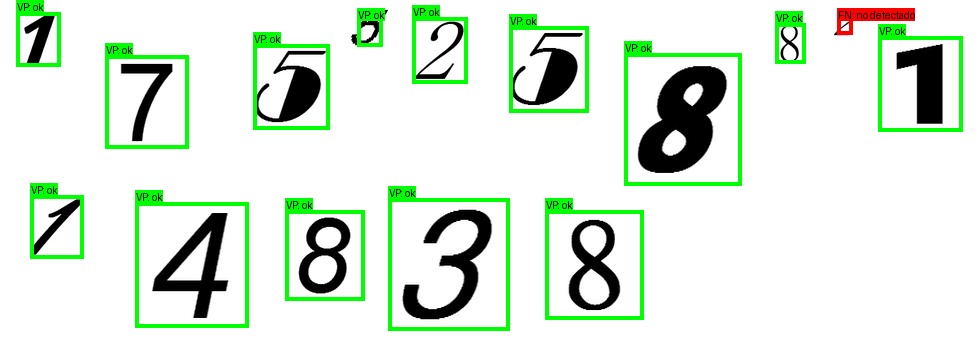

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 14 >  cartel_950176853895760.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 15 >  cartel_758592563307076.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 16 >  cartel_419887660092322.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 17 >  cartel_895421987865572.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 18 >  cartel_888508739486478.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 19 >  cartel_951603850

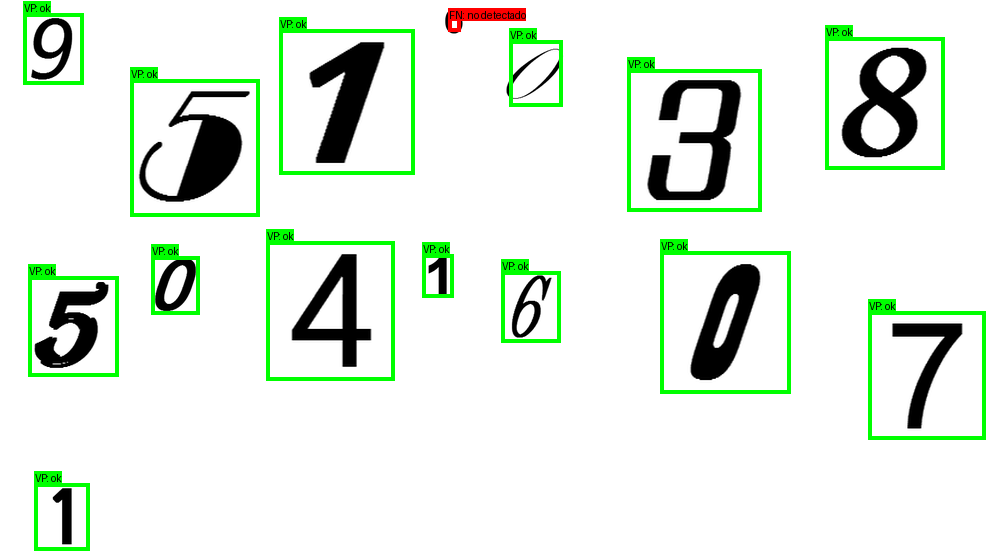

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 20 >  cartel_975651228656150.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 21 >  cartel_917606192484577.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 22 >  cartel_793744535973296.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 23 >  cartel_983909907577518.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 24 >  cartel_081758445537020.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 25 >  cartel_684707628

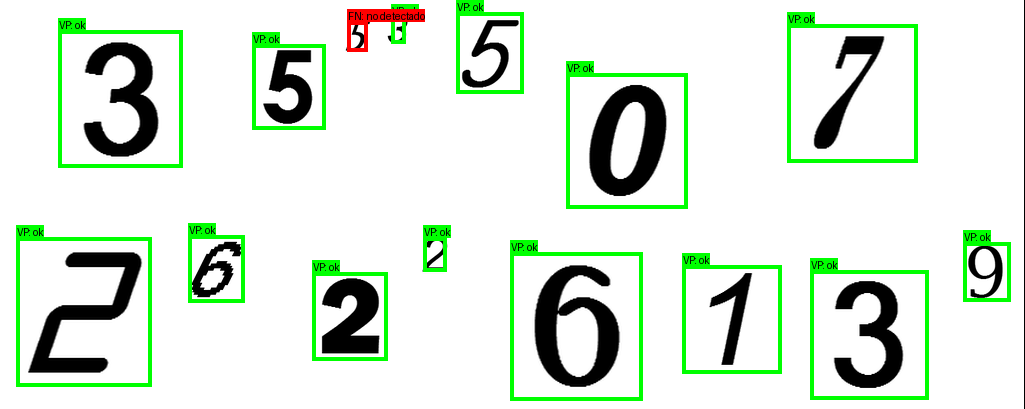

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 28 >  cartel_485024727228414.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 29 >  cartel_669244368512326.png : 


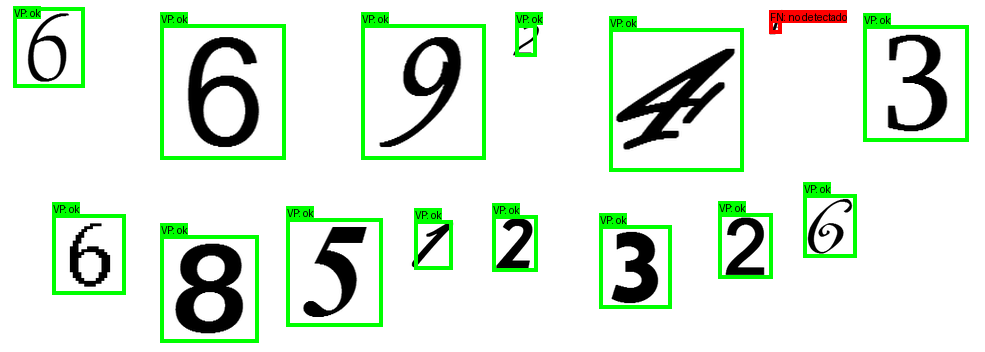

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 30 >  cartel_685066141740136.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 31 >  cartel_587317288399390.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 32 >  cartel_432383644851958.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 33 >  cartel_306697496134767.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 34 >  cartel_833328351744388.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 35 >  cartel_628339719

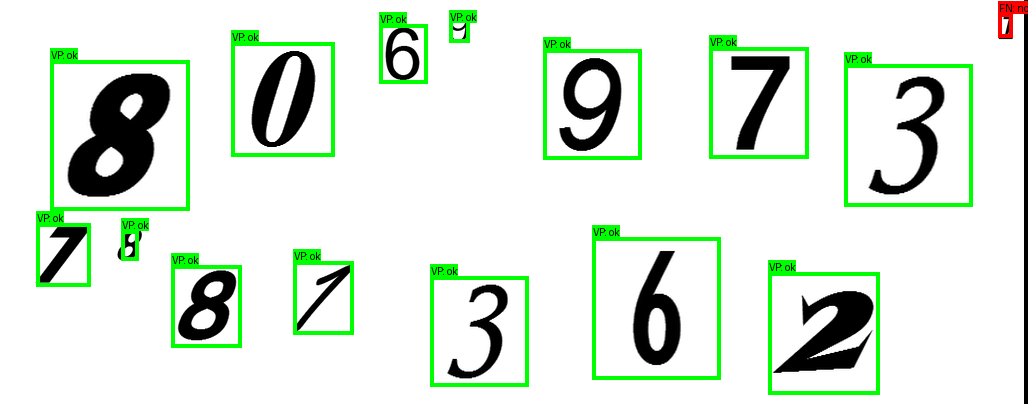

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 38 >  cartel_142924655052617.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 39 >  cartel_557448561571179.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 40 >  cartel_598406725307692.png : 


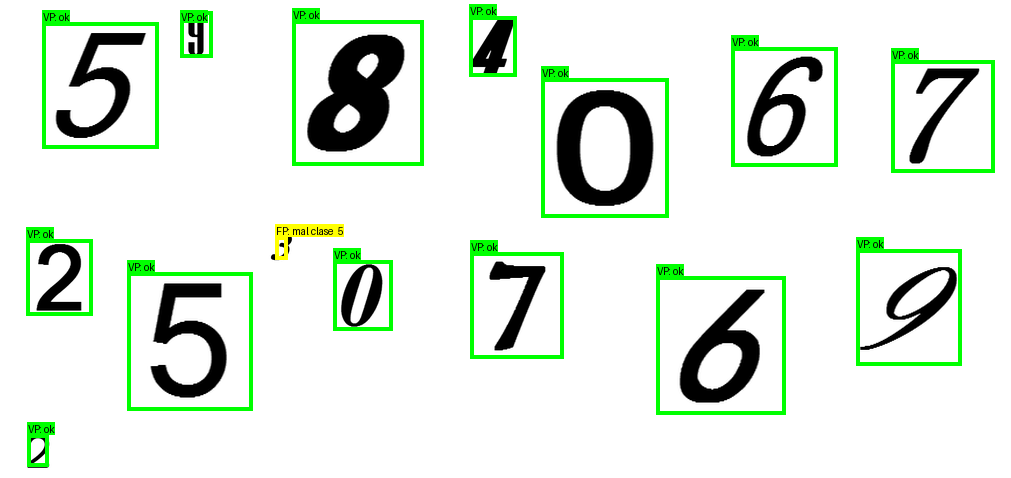

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,0
LABEL:-,1,0




------------------------------------------------------------------------------------------------------------
< 41 >  cartel_973798581091326.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 42 >  cartel_883716090059663.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 43 >  cartel_847352761432492.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 44 >  cartel_373407267637846.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 45 >  cartel_382793321379528.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 46 >  cartel_504157240

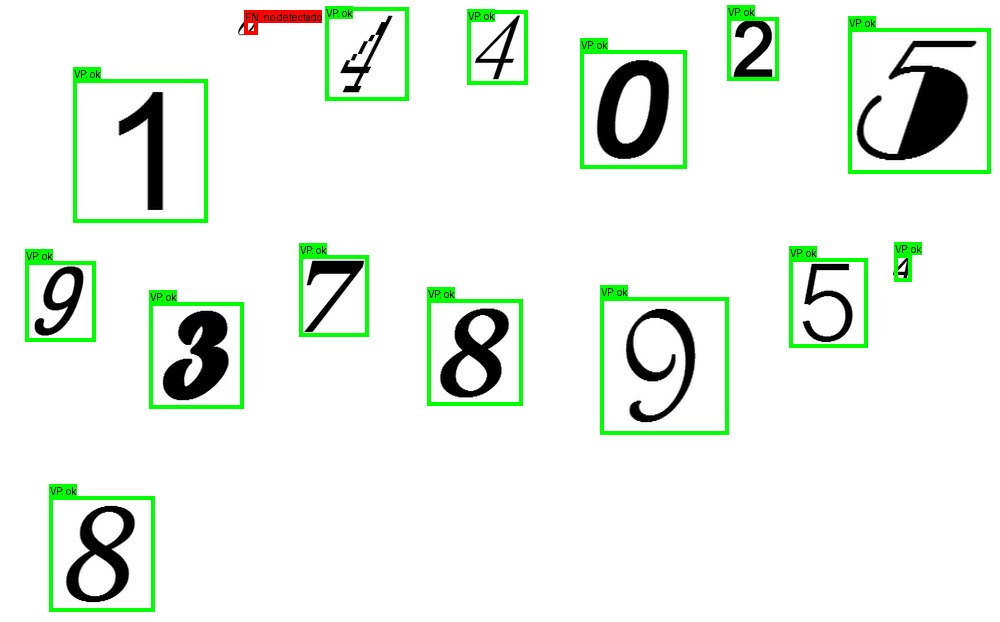

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 48 >  cartel_424018804058676.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 49 >  cartel_623121577186706.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 50 >  cartel_412952792187554.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 51 >  cartel_411029009736315.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 52 >  cartel_761954043688308.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 53 >  cartel_988409838

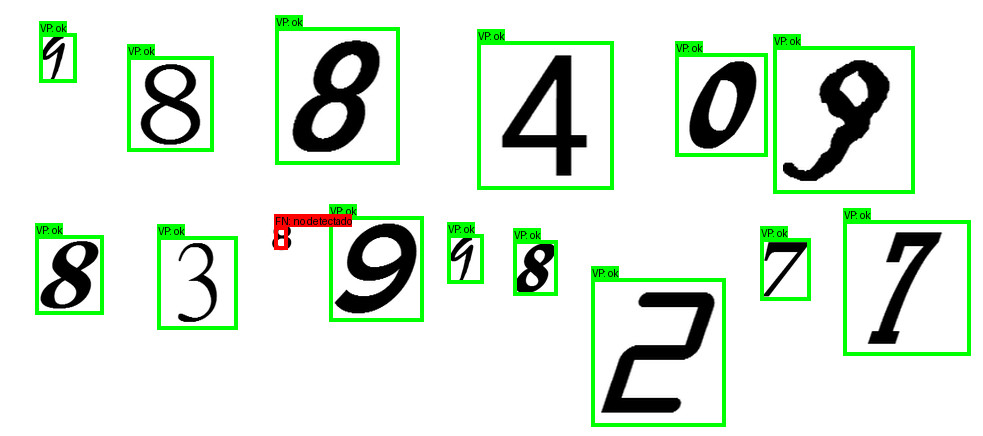

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 54 >  cartel_265854829103749.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 55 >  cartel_378201072197520.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 56 >  cartel_093126174634576.png : 


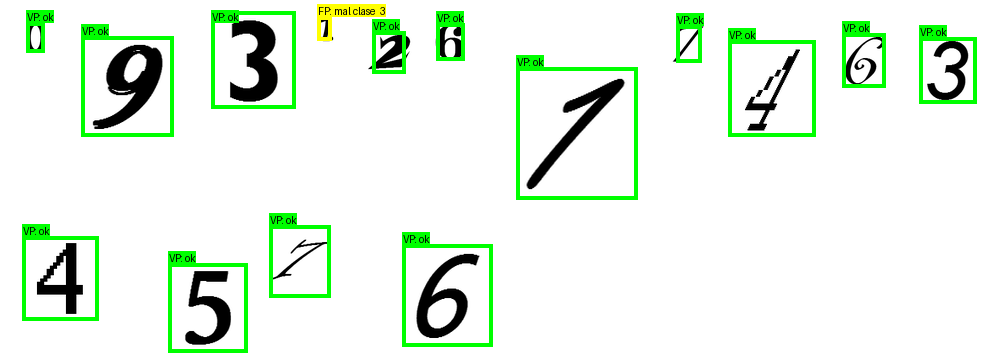

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,0
LABEL:-,1,0




------------------------------------------------------------------------------------------------------------
< 57 >  cartel_899876785511294.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 58 >  cartel_521015551281080.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 59 >  cartel_476419630884287.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 60 >  cartel_496400532431329.png : 


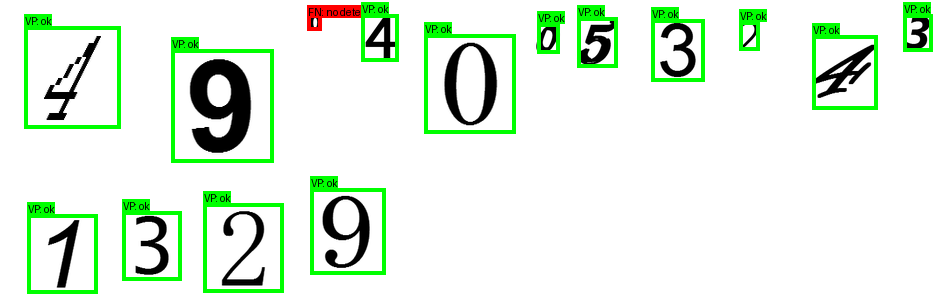

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 61 >  cartel_080998380357851.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 62 >  cartel_143514636918073.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 63 >  cartel_128399191560239.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 64 >  cartel_632872946818610.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 65 >  cartel_087789408581960.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 66 >  cartel_344709814

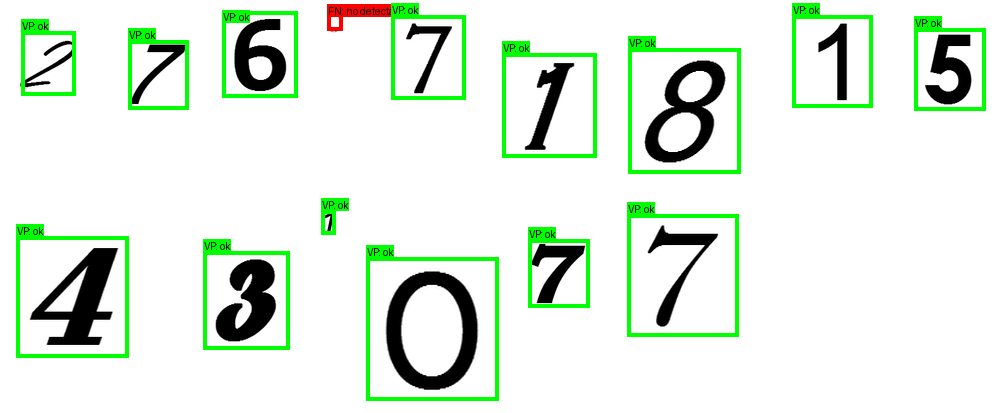

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 70 >  cartel_081873084337995.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 71 >  cartel_992910206102203.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 72 >  cartel_225744341704877.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 73 >  cartel_301735796466353.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 74 >  cartel_650680284441360.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 75 >  cartel_741957952

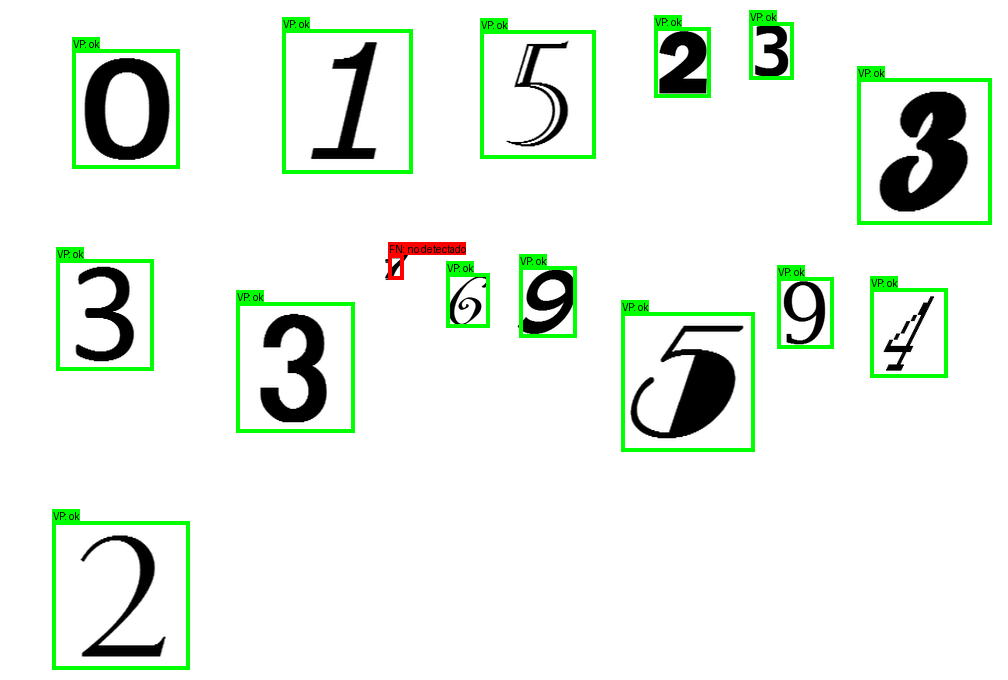

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 77 >  cartel_325395888594184.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 78 >  cartel_030468687869786.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 79 >  cartel_977994878867509.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 80 >  cartel_434988452713644.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 81 >  cartel_307837103410735.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 82 >  cartel_802317767

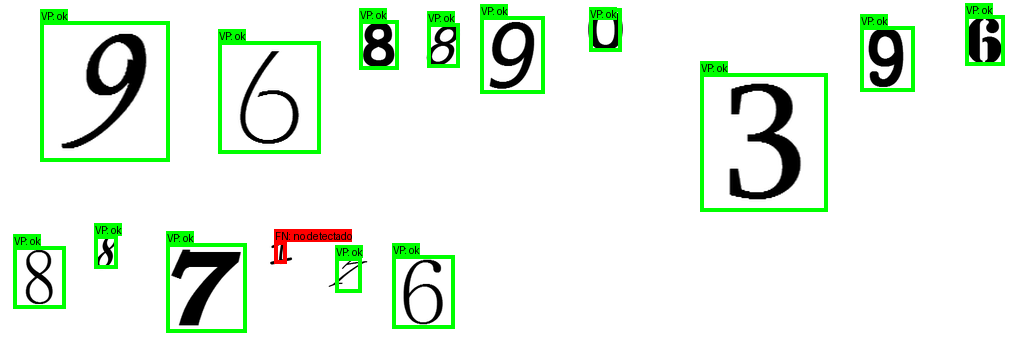

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 84 >  cartel_250470967561209.png : 


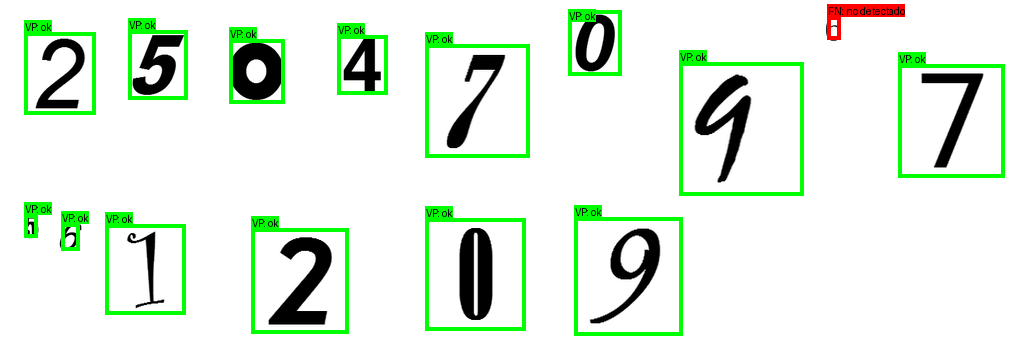

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 85 >  cartel_745025873738172.png : 


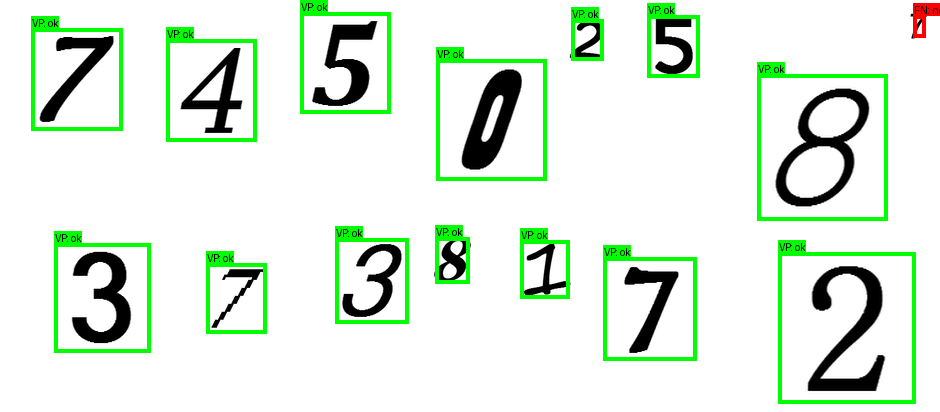

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 86 >  cartel_342294609528180.png : 


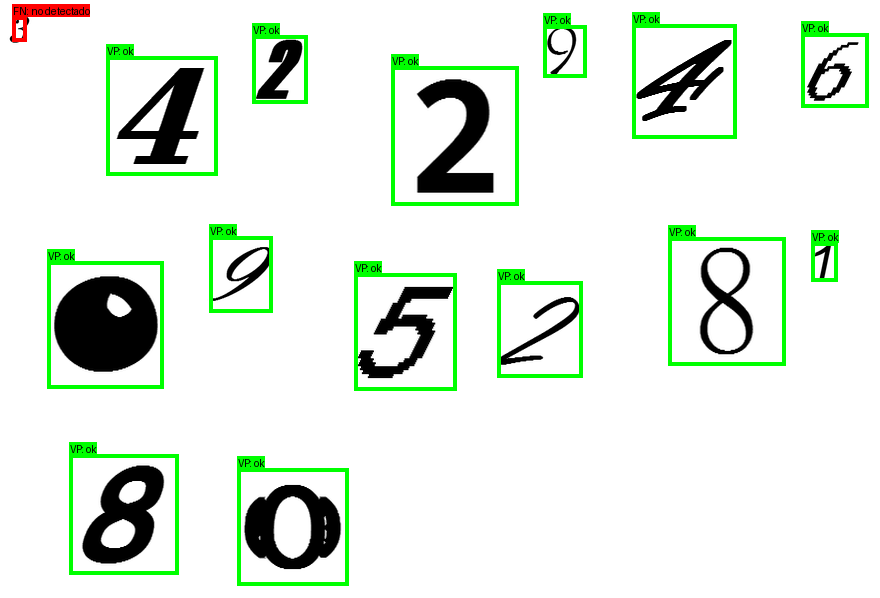

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 87 >  cartel_521369939600450.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 88 >  cartel_491796768051857.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 89 >  cartel_458315092460006.png : 


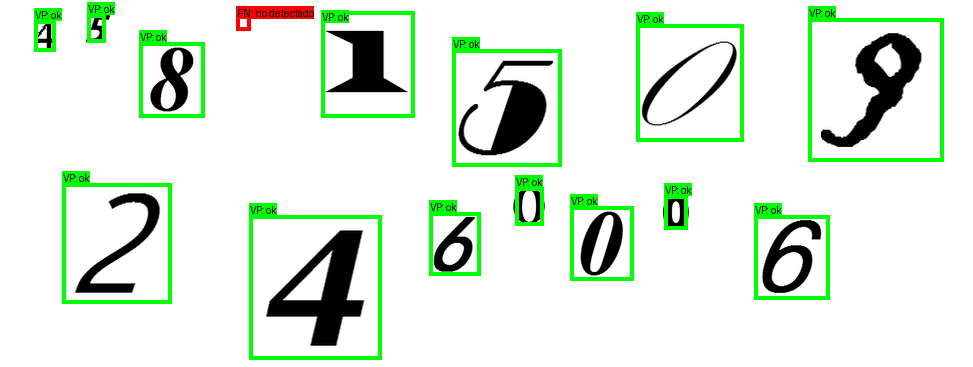

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 90 >  cartel_979523278854457.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 91 >  cartel_941225159963437.png : 


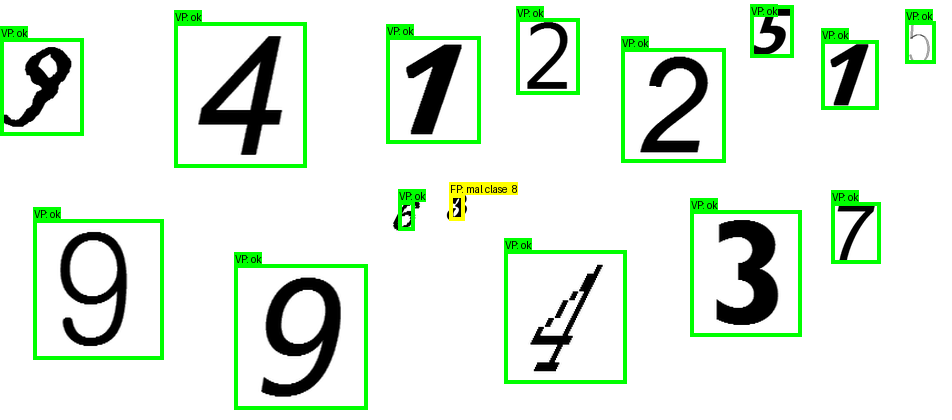

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,0
LABEL:-,1,0




------------------------------------------------------------------------------------------------------------
< 92 >  cartel_921161899514417.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 93 >  cartel_358088774198184.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 94 >  cartel_893944324459559.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 95 >  cartel_851015016968588.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 96 >  cartel_065913620496555.png : 
 ++ sin error detectado.

------------------------------------------------------------------------------------------------------------
< 97 >  cartel_955121826

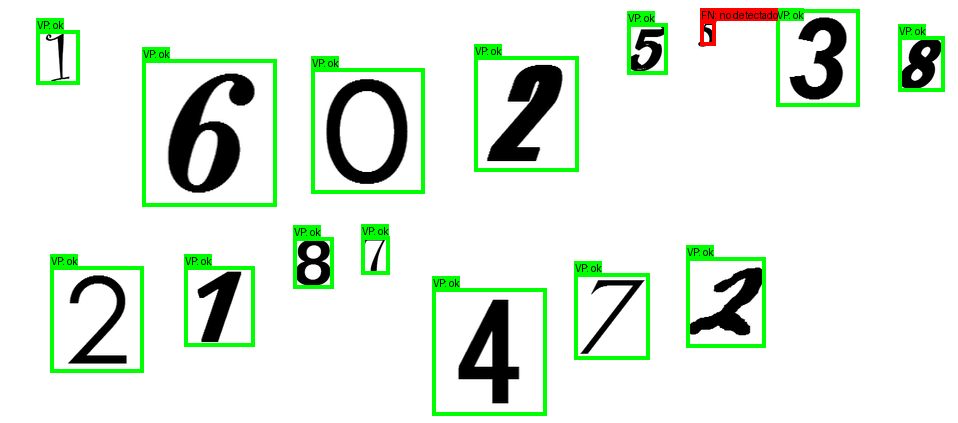

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 99 >  cartel_482442013429217.png : 


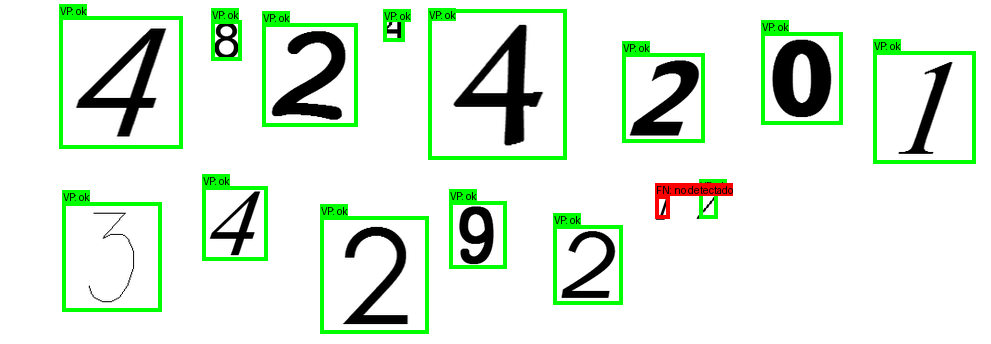

 Nota colores:
     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.
     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO
     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA
     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA 
     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.

> Matriz de Confusión para la Imagen: 


,MODELO:+,MODELO:-
LABEL:+,14,1
LABEL:-,0,0




------------------------------------------------------------------------------------------------------------
< 100 >  cartel_553449938184649.png : 
 ++ sin error detectado.

 == EVALUACIÓN FINALIZADA ==
>> Imágenes revisadas:  100

 >> Imágenes con problemas detectados:  22
	 [ 'cartel_803339561315815.png', 'cartel_531511425477201.png', 'cartel_175525882114838.png', 'cartel_951603850416071.png', 'cartel_355350726226139.png', 'cartel_669244368512326.png', 'cartel_806997317881362.png', 'cartel_598406725307692.png', 'cartel_164402593789548.png', 'cartel_988409838998277.png', 'cartel_093126174634576.png', 'cartel_496400532431329.png', 'cartel_276571815431077.png', 'cartel_015233337695942.png', 'cartel_968890396887176.png', 'cartel_250470967561209.png', 'cartel_745025873738172.png', 'cartel_342294609528180.png', 'cartel_458315092460006.png', 'cartel_941225159963437.png', 'cartel_160255382187472.png', 'cartel_482442013429217.png'] 




In [36]:
#@title Comparar las Imágenes procesadas por el modelo contra XMLs o LABELs

# define minima probabilidad a usar
minimaConfianzaObjectosDetectados = 31 #@param {type:"slider", min:1, max:100, step:1.0}
minConfObjDet = minimaConfianzaObjectosDetectados / 100.0
minConfObjDet = max(min(minConfObjDet, 99), 0)

# define si muestra detalle o no
muestraDetalleDebug = False  #@param {type:"boolean"}
muestraDetalleObjDetectadosEnImagen = False  #@param {type:"boolean"}
muestraDetalleComparacionEnImagen = "Solo con Error" #@param ["Ninguna", "Solo con Error", "Todas"]
muestraDetalleMetricasPorImagen = "Solo con Error" #@param ["Ninguna", "Solo con Error", "Todas"]
muestraDetalleMetricasPorClaseObjeto = True  #@param {type:"boolean"}

# define parámetro Intersection over Union (IoU)
## si calc_IoU(r1, r2) ≥ coefIoU, se considera que se detectó el objecto correctamente, es Verdadero Positivo (VP)
## si calc_IoU(r1, r2) < coefIoU, se considera que se detectó el objecto con error, es Falso Positivo (FP)
## -> valor recomendado por defecto: 0,5
## pero se usa menos para mejorar los resultados
coefIoU = 0.4 #@param {type:"slider", min:0.1, max:1, step:0.1}

# inicializa vector auxiliar para metricas y posiciones a usar
listaConProblemas = []
cantProcesados = 0

# inicializa vectores auxiliares para evaluación de objetos detectados
 # evaluación por clase
classObjModelo = []
classObjReal = []
 # evaluación por tipo resultado (VP, VN, FP, FN)
tipoObjModeloList = []
tipoObjRealList = []

# auxiliar para calcular tiempos del modelo
auxSumaTiempoList = []

# Procesa los XMLs de las imágenes
for img_file in process_Image_FileNames:

    # inicializa vectores auxiliares
    listObjsData = []
    listObjsDetModelo = []

    print("\n------------------------------------------------------------------------------------------------------------")
    cantProcesados = cantProcesados + 1
    print("<", cantProcesados, "> ", img_file, ": ")

    # controla que exista la imagen
    imagenProcesar = dirImg +   img_file
    if not os.path.isfile(imagenProcesar):
      print("\t -- No se encuentra la imagen ", imagenProcesar, "!\n")
      # deja de procesar el y pasa al siguiente
      continue

    # carga la imagen a procesar
    imageCargada = ImPIL.open(imagenProcesar)

    # Convierte la imagen a escala de grises y luego a RGB
    # (para sacarle los colores que tuviera previamente y dejarlo con 3 canales de profundidad)
    imageCargada = imageCargada.convert('L')
    imageCargada = imageCargada.convert('RGB')

    # obtiene el tamaño de la imagen
    im_width, im_height = imageCargada.size

    # carga datos correspondientes
    fn, _ = os.path.splitext(img_file)
    if usarDatosXML:
        dataFN = dirData + fn + ext_archivo_XML
        dataOri = load_XML(dataFN)
    else:
        dataFN = dirData + fn + ext_archivo_LABEL
        dataOri = load_LABEL(dataFN)

    if dataOri is None:
      print("\t -- No se encuentra archivo ", dataFN, "!\n")
      # deja de procesar el y pasa al siguiente
      continue

    if len(dataOri)==0:
      print("\t -- Archivo ", dataFN, "no tiene datos!\n")
      # deja de procesar el y pasa al siguiente
      continue

    # estandariza datos y lo agrega a lista (controlando que no haya duplicados)
    objDataList = preparar_datos_XML_o_Label(usarDatosXML, dataOri,
                                             classes_map,
                                              (im_width, im_height))
    for objData in objDataList:
        if objData not in listObjsData:
          listObjsData.append( objData )

    # convierte la imagen a un array
    ###image_np = np.array(imageCargada)

    # Procesa la imagen con el modelo cargado
    resModel, tiempoDemoraModelo = modelPredict(imageCargada,
                                                classes=classes_map,
                                                showImageResults=muestraDetalleDebug,
                                                verbose=muestraDetalleDebug)
    auxSumaTiempoList.append( tiempoDemoraModelo )

    # estandariza resultados del modelo para facilitar la comparación
    listObjsDetModelo =  preparar_resultados_modelo(resModel,
                                 filter_min_confidence=minConfObjDet,
                                 muestraDebug=muestraDetalleDebug)

    # ordena por el centroide las dos listas
    listObjsData = sorted(listObjsData, key=lambda objDet: objDet[0])
    listObjsDetModelo = sorted(listObjsDetModelo, key=lambda objDet: objDet[0])

    if muestraDetalleDebug:
        print("\n- Objetos de " + tipo_datos_comparar + ":")
        print(len(listObjsData), " : ",listObjsData)

        print("\n- Objetos detectados por el Modelo:")
        print(len(listObjsDetModelo), " : ", listObjsDetModelo)

    if muestraDetalleObjDetectadosEnImagen:

        print("\n- Muestra los objetos del " + tipo_datos_comparar + " y Detectados en la Imagen:")
        # imagen auxiliar para mostrar recuadros de XML y modelo
        image_pil = copy.deepcopy(imageCargada.convert("RGB"))
        draw = ImageDraw.Draw(image_pil)


        # genera los recuadros correspondientes del XML (en color verde)
        draw_boxes_listObj(draw, listObjsData, lineColor=(0,255,0), lineWidth=8)

        # genera los recuadros correspondientes al Modelo (en color azul)
        draw_boxes_listObj(draw, listObjsDetModelo, lineColor=(0,0,255), lineWidth=4)

        imMostrar = ImPIL.fromarray(np.array(image_pil))#, 'RGB')
        display( imMostrar )
        print(" Nota colores:")
        print("    Objetos definidos en " + tipo_datos_comparar + ", cuadros en VERDE.")
        print("    Objetos detectados por el Modelo, cuadros en AZUL.")
        print("\n")

    # Realiza la compración de los objetos definidos en el XML contra los detectados por el modelo
    if muestraDetalleDebug:
        print("+ Realiza la Comparación: ")

    resCompara = []
    auxlistObjsDetModelo = copy.copy(listObjsDetModelo)

    # Busca el objeto del XML en la lista de objetos detectados por el Modelo
    # (para eso considera la ubicación y tipo de clase)
    for objData in listObjsData:
        i = -1
        noEnc = True
        while noEnc and i < (len(auxlistObjsDetModelo)-1):
          i = i + 1

          # calcula la Intersection over Union (IoU) de los boxes
          objIoU = calc_IoU( objData[2], auxlistObjsDetModelo[i][2] )

          # si el IoU es casi perfecto, considera que es el objeto
          #if objIoU > 0.90:
          #  noEnc = False
          #else:
           #  analiza si tiene algo de superposición y es de la misma clase
          noEnc = not((objIoU > 0.1) and (objData[1] == auxlistObjsDetModelo[i][1]))

        if noEnc:
           # Si no se encuentra objeto con misma ubicación y clase del XML
          if muestraDetalleDebug:
              print(objData[1], " no detectado por el Modelo con misma ubicación y clase ")

          # registra que ese objeto no se encontró
          resCompara.append(  (objData[1], -1, objData[2], "-") )

        else:
          # Si encuentra objecto en misma ubicación y  clase del XML
          if muestraDetalleDebug:
              print(objData[1], ": ", objIoU)

          # regista que el objeto se encontró con su IoU
          resCompara.append(  (objData[1], objIoU, auxlistObjsDetModelo[i][2], auxlistObjsDetModelo[i][1]) )

          # saca el objeto de la lista auxiliar para que no se vuelva a usar
          auxlistObjsDetModelo.pop(i)

    # Revisa los objetos detectados que no se utilizaron en la comparación anterior
    # para incluir en la comparación
    #  objetos en la misma ubicación pero  con distinta clase
    #   u objetos detectados que no figuran en el XML
    if len(auxlistObjsDetModelo) > 0:
      if muestraDetalleDebug:
        print("\n-Se intenta asociar con ", len(auxlistObjsDetModelo), " objetos detectados del Modelo no utilizados")

      for objDet in auxlistObjsDetModelo:
        # lo compara con los que no se puedieron detectar
        i = 0
        cont = True
        while cont and i < len(resCompara):

            # sólo procesa es un objeto del XML no encontrado en Modelo
            if (resCompara[i][1] < 0):
                # calcula la Intersection over Union (IoU) de los boxes
                objIoU = calc_IoU( resCompara[i][2], objDet[2] )

                if objIoU >= coefIoU:
                      # si están superpuestos se considera que se detectó pero le asignó mal la clase
                      resCompara[i] = (resCompara[i][0], objIoU, objDet[2], objDet[1] )
                      cont = False

                      if muestraDetalleDebug:
                          print("--- Se rectifica objeto no detectado: ", resCompara[i])
            i = i + 1

        if cont:
          # si no se utiliza, se agrega como objeto detectado de más
          resCompara.append(  ("-", 999, objDet[2], objDet[1]) )

          if muestraDetalleDebug:
              print("--- Se agrega objeto detectado por Modelo de más: ", objDet[1])

    if muestraDetalleDebug:
        print("\n+ Resultados de la Comparación:")
        print( len(resCompara), " : ", resCompara )


    ## ---------------------------------------------------------------------------------------------
    # Realiza el cálculo de las Métricas de la Imagen considerando los resultados de la comparación
    ## ---------------------------------------------------------------------------------------------
    ## Nota los Verdadero Negativo (VN) se deberían calcular considerando el resto de la imagen
    ## que no tiene objetos, por lo que no es útil para Modelos de Object Detection y no se utiliza.
    ## ---------------------------------------------------------------------------------------------
    tipoObjModeloList_im = []
    tipoObjRealList_im = []

    hayErrorDetectado = False
    generaImagenComparacion = (muestraDetalleComparacionEnImagen != "Ninguna")
    if generaImagenComparacion:
      # imagen auxiliar para mostrar resultados comparación
      comp_image_pil = copy.deepcopy(imageCargada.convert("RGB"))
      comp_draw = ImageDraw.Draw(comp_image_pil)
      im_width, im_height = comp_image_pil.size

    for resObj in resCompara:

        if muestraDetalleMetricasPorClaseObjeto:
          # agrega en vectores auxiliares para hacer la evaluación por clase
          classObjReal.append( resObj[0] )
          classObjModelo.append( resObj[3] )

        if (resObj[0] == resObj[3]) and (resObj[1] >= coefIoU):
            # Objeto de misma Clase entre DATA y Modelo con IoU ≥ coefIoU -> Verdadero Positivo (VP)
            tipoObjModeloList_im.append( "+" )
            tipoObjRealList_im.append( "+" )
            if generaImagenComparacion:
              colorBox = (0,255,0) # cuadros Verdes
              textDraw = "VP: ok" # detalle texto
              # dibuja rectangulo con texto
              draw_box_on_image(comp_draw, box=resObj[2], lineColor=colorBox, line_width=4, label=textDraw)

        elif resObj[1] < 0:
            # Objecto de DATA no encontrado en Modelo -> Falso Negativo (FN)
            tipoObjModeloList_im.append( "-" )
            tipoObjRealList_im.append( "+" )
            hayErrorDetectado = True
            if generaImagenComparacion:
              colorBox =  (255,0,0) # cuadros Rojos
              textDraw = "FN: no detectado" # detalle texto
              # dibuja rectangulo con texto
              draw_box_on_image(comp_draw, box=resObj[2], lineColor=colorBox, line_width=4, label=textDraw)

        else:
            # Objeto de misma Clase entre DATA y Modelo con calc_IoU(r1, r2) < coefIoU -> Falso Positivo (FP)
            # Objeto de distinta Clase entre DATA y Modelo con calc_IoU(r1, r2) ≥ coefIoU -> Falso Positivo (FP)
            # Objeto detectado por el Modelo que no aparece en el Modelo -> Falso Positivo (FP)
            tipoObjModeloList_im.append( "+" )
            tipoObjRealList_im.append( "-" )
            hayErrorDetectado = True
            if generaImagenComparacion:
              if resObj[1] == 999:
                # detectados de más por el Modelo
                colorBox = (255,155,255) # cuadros Rosa
                textDraw = "FP: detecta de más" # detalle texto
              elif (resObj[0] != resObj[3]):
                # misma ubicación y distinta clase
                colorBox = (255,255,0) # cuadros Amarillo
                textDraw = "FP: mal clase  "+str(resObj[3]) # detalle texto
              else:
                # diferencia de ubicación y misma clase
                colorBox = (255,155,0) # cuadros Naranja
                textDraw = "FP: mal ubicacion" # detalle texto
              # dibuja rectangulo con texto
              draw_box_on_image(comp_draw, box=resObj[2], lineColor=colorBox, line_width=4, label=textDraw)

    # acumula para métricas generales
    tipoObjModeloList.extend( tipoObjModeloList_im )
    tipoObjRealList.extend( tipoObjRealList_im )

    if hayErrorDetectado:
          listaConProblemas.append( img_file )

    if generaImagenComparacion and ( (muestraDetalleComparacionEnImagen == "Todas") or ( hayErrorDetectado and (muestraDetalleComparacionEnImagen == "Solo con Error") ) ):

        imMostrar = ImPIL.fromarray(np.array(comp_image_pil))#, 'RGB')
        display( imMostrar )
        print(" Nota colores:")
        print("     Verdaderos Positivos (igual ubicación y misma clase): cuadros en VERDE.")
        print("     Falsos Positivos (misma ubicación y distinta clase): cuadro en  AMARILLO")
        print("     Falsos Positivos (diferencia de ubicación y misma clase): cuadros en NARANJA")
        print("     Falsos Positivos (detectados de más por el Modelo): cuadros en ROSA ")
        print("     Falsos Negativos (no detectado por el Modelo): cuadros en ROJO.")

    if ( (muestraDetalleMetricasPorImagen == "Todas") or ( hayErrorDetectado and (muestraDetalleMetricasPorImagen == "Solo con Error") ) ):
        mostrarMetricas(tipoObjRealList_im, tipoObjModeloList_im, titulo="para la Imagen",
                        etiqueta_modelo="MODELO", etiqueta_real=tipo_datos_comparar )
    else:
        if hayErrorDetectado:
            print(" -- se detecta al menos un error!")
        else:
            print(" ++ sin error detectado.")

print("\n == EVALUACIÓN FINALIZADA ==")
print(">> Imágenes revisadas: ", cantProcesados)

auxLista = '['
if len(listaConProblemas)>0:
  for f in listaConProblemas:
      auxLista = auxLista + " '" + f + "',"
  auxLista = auxLista[:len(auxLista)-1]
auxLista = auxLista + ']'
print("\n >> Imágenes con problemas detectados: ", len(listaConProblemas) )
print("\t", auxLista, "\n")
print("")



> Matriz de Confusión General del Modelo Entrenado: 


,MODELO:+,MODELO:-
LABEL:+,1478,18
LABEL:-,4,0


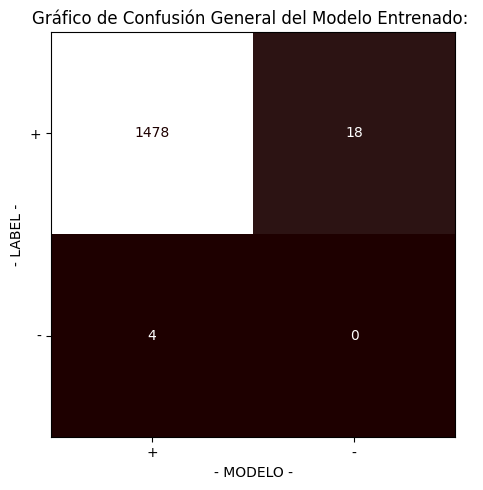



> Reporte de Clasificación General del Modelo Entrenado: 
              precision    recall  f1-score   support

           +       1.00      0.99      0.99      1496
           -       0.00      0.00      0.00         4

    accuracy                           0.99      1500
   macro avg       0.50      0.49      0.50      1500
weighted avg       0.99      0.99      0.99      1500




# Estadísticas del tiempo que demora ejecutar el modelo:
 		- Minimo: 0.166177 segundos. 
 		- Promedio: 0.210726 segundos. 
 		- Máximo:  0.359789 segundos. 




In [37]:
#@title Mostrar las Métricas Generales

mostrarMetricas(tipoObjRealList, tipoObjModeloList, "General del Modelo Entrenado",
                showConfussionGraph=True, showClassReport=True,
                etiqueta_modelo="MODELO", etiqueta_real=tipo_datos_comparar )

# Muestra tiempo de ejecución promedio
if len(auxSumaTiempoList)>0:
  print("\n\n# Estadísticas del tiempo que demora ejecutar el modelo:")
  print(" \t\t- Minimo:",  round(np.min(auxSumaTiempoList), 6), "segundos. ")
  print(" \t\t- Promedio:",  round(np.average(auxSumaTiempoList), 6), "segundos. ")
  print(" \t\t- Máximo: ",  round(np.max(auxSumaTiempoList), 6), "segundos. ")
  print("\n")




> Matriz de Confusión por Clase del Modelo Entrenado: 


,MODELO:-,MODELO:0,MODELO:1,MODELO:2,MODELO:3,MODELO:4,MODELO:5,MODELO:6,MODELO:7,MODELO:8,MODELO:9
LABEL:-,0,0,0,0,0,0,0,0,0,0,0
LABEL:0,0,135,0,0,0,0,0,0,0,0,0
LABEL:1,3,0,148,0,1,0,0,0,0,0,0
LABEL:2,2,0,0,125,0,0,0,0,0,0,0
LABEL:3,2,0,0,0,140,0,2,0,0,1,0
LABEL:4,1,0,0,0,0,146,0,0,0,0,0
LABEL:5,3,0,0,0,0,0,160,0,0,0,0
LABEL:6,4,0,0,0,0,0,0,133,0,0,0
LABEL:7,2,0,0,0,0,0,0,0,169,0,0
LABEL:8,1,0,0,0,0,0,0,0,0,172,0


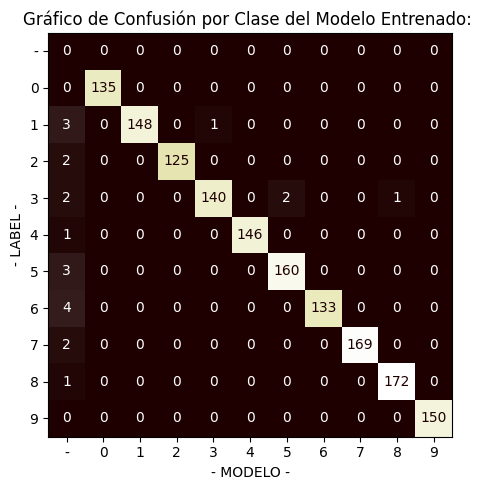



> Reporte de Clasificación por Clase del Modelo Entrenado: 
              precision    recall  f1-score   support

           -       0.00      1.00      0.00         0
           0       1.00      1.00      1.00       135
           1       1.00      0.97      0.99       152
           2       1.00      0.98      0.99       127
           3       0.99      0.97      0.98       145
           4       1.00      0.99      1.00       147
           5       0.99      0.98      0.98       163
           6       1.00      0.97      0.99       137
           7       1.00      0.99      0.99       171
           8       0.99      0.99      0.99       173
           9       1.00      1.00      1.00       150

    accuracy                           0.99      1500
   macro avg       0.91      0.99      0.90      1500
weighted avg       1.00      0.99      0.99      1500




In [38]:
#@title Mostrar las Métricas Detalladas por Clase


mostrarMetricas(classObjReal, classObjModelo, "por Clase del Modelo Entrenado",
                showConfussionGraph=True, showClassReport=True,
                etiqueta_modelo="MODELO", etiqueta_real=tipo_datos_comparar )
